In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

In [3]:
from entsoe import EntsoePandasClient
import pandas as pd

entsoe_client = EntsoePandasClient(api_key=os.getenv('ENTSOE_API_KEY'))

df = entsoe_client.query_load_and_forecast(
    country_code="CH", 
    start=pd.Timestamp('2013-01-01 00:00', tz="Europe/Zurich"), 
    end=pd.Timestamp('2025-01-01 00:00', tz="Europe/Zurich"),
)
df.head(5)

,Forecasted Load,Actual Load
2014-10-24 00:00:00+02:00,NaN,6522.0
2014-10-24 01:00:00+02:00,NaN,6342.0
2014-10-24 02:00:00+02:00,NaN,6269.0
2014-10-24 03:00:00+02:00,NaN,6230.0
2014-10-24 04:00:00+02:00,NaN,6257.0


In [4]:
df_ = df.copy()

In [24]:
df = df_.copy()

# Wrangling

In [80]:
df = df_.copy()[['Actual Load']]

In [81]:
from datetime import timedelta

df = df.set_index(df.index - timedelta(hours=24))
df = df.rename(columns={'Actual Load': '24h_later_load'})
df.head()

,24h_later_load
2014-10-23 00:00:00+02:00,6522.0
2014-10-23 01:00:00+02:00,6342.0
2014-10-23 02:00:00+02:00,6269.0
2014-10-23 03:00:00+02:00,6230.0
2014-10-23 04:00:00+02:00,6257.0


# Dummy baseline

In [82]:
from datetime import timedelta
from sklearn.metrics import mean_absolute_percentage_error

# Enrich the data with the 24h_ago_load
df = df.asfreq('h') # Enforce an hourly frequency
df['24h_ago_load'] = df['24h_later_load'].shift(48)

# Only consider the last year
with_load_latest_ts = df[~df['24h_later_load'].isna()].index.max() 
df = df[df.index >= with_load_latest_ts - timedelta(days=365)]

# Build y_true and y_pred
df = df.dropna()
y_true = df['24h_later_load']
y_pred = df['24h_ago_load']
print(f'MAPE over the last year: {mean_absolute_percentage_error(y_true, y_pred) * 100:.2f}%') 
# MAPE over the last year: 8.97%

MAPE over the last year: 8.97%


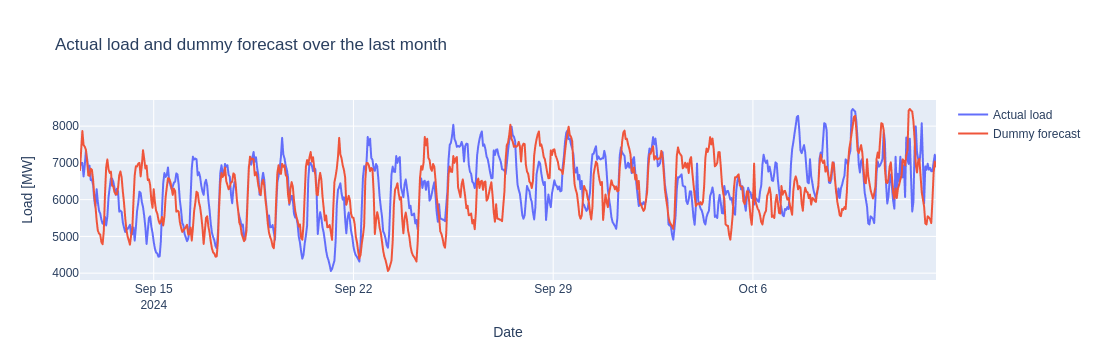

In [87]:
import plotly.express as px

# Plot the last month
df = df[df.index >= df.index.max() - timedelta(days=30)]

fig = px.line(
    df, x=df.index, y=['24h_later_load', '24h_ago_load'], 
    title='Actual load and dummy forecast over the last month',
    labels={'index': 'Date', 'value': 'Load [MW]', 'variable': ''}
)

fig.for_each_trace(lambda t: t.update(name={'24h_later_load': 'Actual load', '24h_ago_load': 'Dummy forecast'}[t.name]))

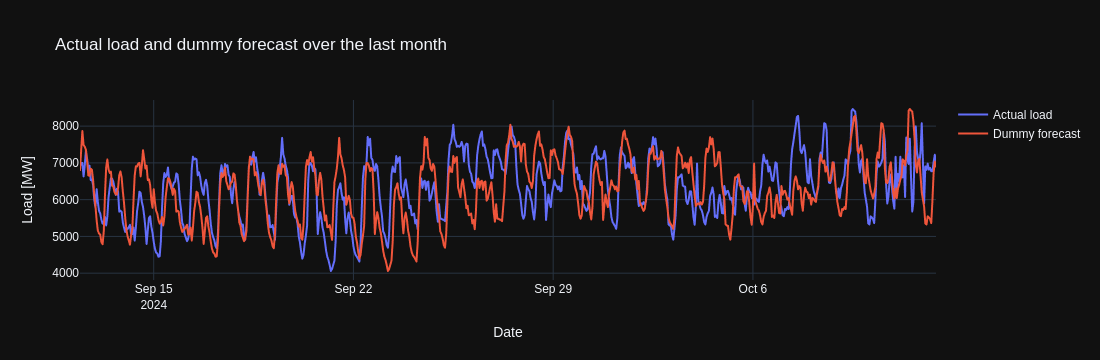

In [88]:
fig.layout.template = "plotly_dark"
fig.show()

In [89]:
fig.write_html("dummy_forecast_lineplot.html", include_plotlyjs='cdn')

# MAPE timeframes